MAP fitter for RFI time series. Heavily WIP.

In [156]:
##Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from SSINS import INS
import os
import scipy.linalg as la
from scipy.signal.windows import dpss
from scipy.optimize import minimize
from itertools import combinations
from custom_funcs import chan_avg, chan_select

##Setting font size
plt.rcParams.update({'font.size': 16,
                     'font.family': 'serif',
                     'font.serif': 'Times New Roman'})

In [157]:
##Importing data file from Data folder

#Defining the data directory and night in file name
data_dir = "Data"
night = "109035_p4"

#Constructing datapath and constructing ins object using SSINS
datapath = os.path.join(data_dir, night + "_SSINS_data.h5")
maskpath = os.path.join(data_dir, night + "_SSINS_mask.h5")
ins = INS(datapath, telescope_name='MWA', mask_file=maskpath)

#Defining shape dictionary
TV_dict = {
    'TV6': [1.74e8, 1.81e8],
    'TV7': [1.81e8, 1.88e8],
    'TV8': [1.88e8, 1.95e8],
    'TV9': [1.95e8, 2.02e8]
    }

#Selecting one DTV subband
chan_name = 'TV7'

#Extracting and averaging over the selected subband
ins_subband, masked_ins, N_bl, N_freq = chan_select(ins, chan_name, TV_dict)
time, amp = chan_avg(ins_subband)
masked_time, masked_amp = chan_avg(masked_ins)

invalid value encountered in multiply
invalid value encountered in divide
sig_array has been reset


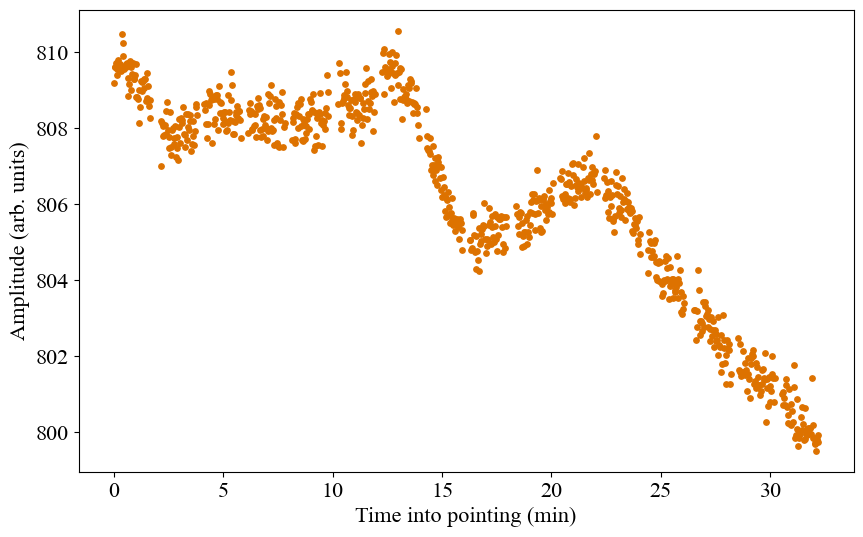

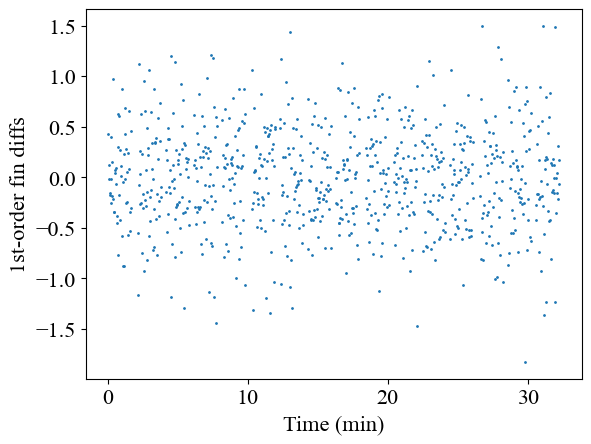

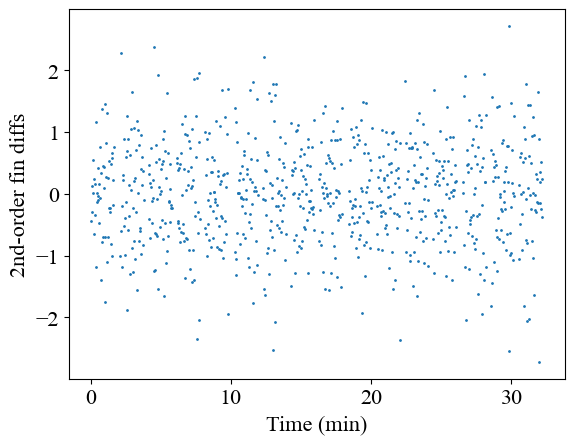

[809.18470993 809.61174942 809.59791721 809.7144602  809.54367027
 809.39036944 809.79097539 809.53938763 809.524032   809.67226397
 809.48405748 810.45602266 810.24112148 809.8947914  809.55516992
 809.62890082 809.66623979 809.60155505 809.69139751 809.30594655
 808.84943348 809.14407338 809.76900079 808.99672736 809.60241268
 809.42660955 809.69930257 809.27540567 809.28565092 809.39674899
 808.81603734 809.68983516 808.81415402 808.76820611 808.99790271
 808.11983728 808.54650613 809.23136408 809.21744096 808.96645033
 809.24266369 809.29059554 809.04728878 809.29049494 808.7160004
 808.79442138 809.44959067 809.10308457 808.57609454 808.26846507
 808.72479636 808.17099764 807.00735753 808.12227201 808.05027493
 807.78606554 807.82193119 808.08414007 807.82636491 808.45011069
 808.68310379 807.93047147 807.76792182 807.4672439  808.42249921
 807.49869225 807.27422309 807.93282756 808.00219043 807.71977174
 807.57255396 808.05594451 807.23648298 807.46038992 807.75147241
 807.167830

In [158]:
#Some auxiliary code for plotting time series that I've been working with

#plt.scatter((time[1:]-time[1])*24*60*60, np.diff(amp)/(np.diff(time)*24*60*60), s=1)

plt.figure(figsize=(10, 6))
plt.scatter((time[0:]-time[0])*24*60, amp, s=15, color="#dd7200")
plt.xlabel("Time into pointing (min)")
plt.ylabel("Amplitude (arb. units)")
f""" or i in range(12):
    plt.axvline(x=i*(time.max() - time[0])*24*60/11, linestyle='--', color="#00c8b8") """
plt.show()

plt.scatter((time[1:] - time[0])*24*60, np.diff(amp), s=1)
plt.xlabel('Time (min)')
plt.ylabel('1st-order fin diffs')
plt.show()
plt.scatter((time[2:] - time[0])*24*60, np.diff(np.diff(amp)), s=1)
plt.xlabel('Time (min)')
plt.ylabel('2nd-order fin diffs')
plt.show()

print(amp)

In [159]:
##Previous data for constructing prior on RFI emission parameters

#Peaks, SSINS amplitudes (arb units)
peaks=np.array([53.35432366, 8.97030183, 39.32910956, 28.3103236, 30.93772398, 36.2624972, 15.55913153, 44.21889192,
       44.9823896, 36.18116225, 25.08418434, 33.37233714, 51.98871383, 71.11015838, 25.76393398, 17.09304232, 
       6.0885566, 11.14962293, 52.29949963, 44.91604231, 23.85311619, 57.59864797, 1.21500878e+01, 4.57578285e+01,
       43.16161392, 51.0379999, 16.44774823, 53.31619823, 85.09920858, 10.72147938, 18.26272233, 37.61133042,
       11.1810082, 12.82857739, 51.49711535, 20.3400262, 34.50876787, 46.37546283, 35.81477314, 36.96341681,
       9.18631159, 33.3049884, 6.10809826, 18.75778949, 26.21931248, 46.57467886, 22.82709187, 18.69584422,
       56.140001, 66.05041274, 61.65063534, 5.5279846, 7.64796047, 59.34091678, 63.71339591, 38.23994538])


#Time into pointing/length of pointing -- want flat
loc=np.array([0.39361857, 0.94595976, 0.52309947, 0.1174075, 0.42087645, 0.55030397, 0.96448721, 0.95354939,
     0.5667833, 0.9647058, 0.13256501, 0.52036559, 0.18725956, 0.53959978, 0.81926798, 0.85710116, 
     0.19789189, 0.56327705, 0.62144842, 0.11526984, 0.44578389, 0.15972674, 1.84629939e-01, 8.81903585e-01,
     2.53746154e-01, 3.52378053e-01, 6.56658287e-01, 0.20640947, 0.9842502, 0.82448753, 0.79864468, 0.82609582,
     0.11022169, 0.07753185, 0.57244621, 0.0896191, 0.64090821, 0.4027631, 0.24795562, 0.72001842,
     0.10122139, 0.25738608, 0.64577568, 0.68554986, 0.45178244, 0.82402821, 0.16167855, 0.25189232,
     0.45948544, 0.53000544, 0.94603795, 0.41958575, 0.94060631, 0.4551634, 0.96417559, 0.68670813])

#Durations (s)
widths=np.array([46.35740966, 47.78082138, 52.01985143, 51.1243677, 48.66579981, 62.63576724, 51.55184647, 64.54810228,
        68.97618067, 63.08569669, 56.8891352, 64.68566024, 54.74073774, 57.955234, 35.92143505, 32.08070818,
        74.16922759, 57.12015228, 69.59804093, 65.70437593, 47.97567077, 82.01174163, 6.44723034e+01, 6.44048269e+01,
        6.87384350e+01, 6.99024843e+01, 5.66360677e+01, 73.41190595, 97.88771772, 38.34149624, 40.48260042, 62.84866352,
        39.34094184, 43.88357933, 68.20029216, 55.17499495, 59.64828645, 65.16642306, 59.59367969, 57.69014685,
        39.30030286, 25.61981977, 60.45653745, 36.25104968, 50.26782436, 66.64052355, 64.69421242, 35.47301949,
        57.35702717, 62.72083288, 57.83072425, 72.39670654, 7.68408292e+01, 56.47607773, 58.60065642, 58.92762818])


widths = np.sort(widths)/60/60/24   #Rescaling to Julian time units
loc = np.sort(loc)
peaks = np.sort(peaks)

#Constructing our prior sample matrix
theta_0 = np.vstack((peaks, loc*(np.max(time) - np.min(time)), widths))

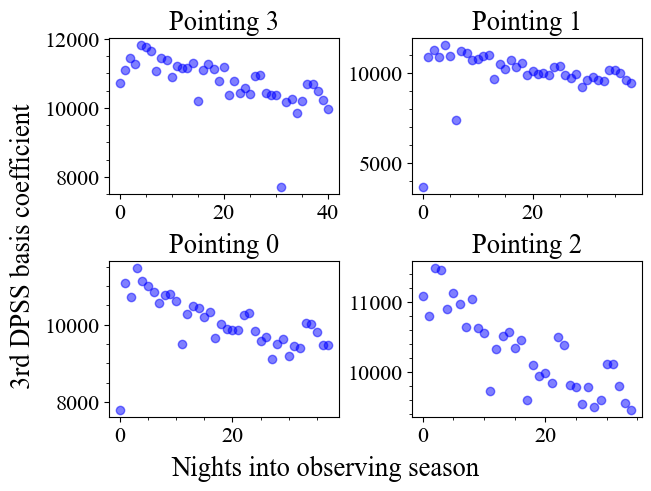

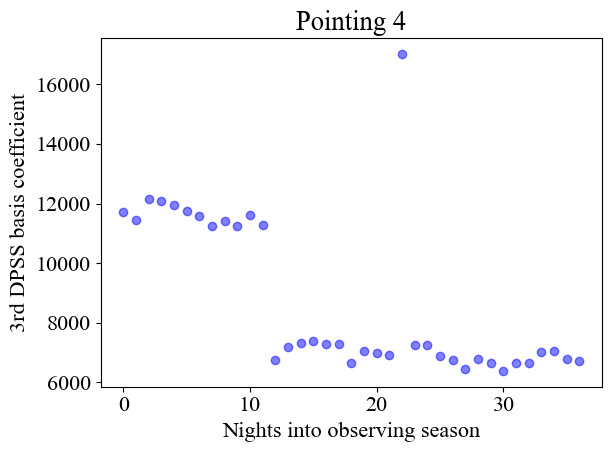

In [160]:
##Constructing our DPSS fit coefficient prior

c0 = np.load('Data/coefficients_p0.npy')
c1 = np.load('Data/coefficients_p1.npy')
c2 = np.load('Data/coefficients_p2.npy')
c3 = np.load('Data/coefficients_p3.npy')
c4 = np.load('Data/coefficients_p4.npy')

samples = np.concatenate((c0, c1, c2, c3))


##Defining our subplots -- one at a time
fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
ax[0, 0].minorticks_on()
ax[1, 0].minorticks_on()
ax[0, 1].minorticks_on()
ax[1, 1].minorticks_on()

ax[0, 0].scatter(np.arange(len(c3[::4])), c3[:, 2][::4], alpha=0.5, label='p3', color='blue')
ax[0, 0].set_title("Pointing 3")
poly_design = np.vander(np.arange(len(c3))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c3[:, 2][::4]
res = c3[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[0, 0].plot(np.arange(len(c3))[::4], poly_design @ poly_fit)
#ax[0, 0].fill_between(np.arange(len(c3))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)

ax[0, 1].scatter(np.arange(len(c1[::4])), c1[:, 2][::4], alpha=0.5, label='p1', color='blue')
ax[0, 1].set_title("Pointing 1")
poly_design = np.vander(np.arange(len(c1))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c1[:, 2][::4]
res = c1[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[0, 1].plot(np.arange(len(c1))[::4], poly_design @ poly_fit)
#ax[0, 1].fill_between(np.arange(len(c1))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


ax[1, 0].scatter(np.arange(len(c0[::4])), c0[:, 2][::4], alpha=0.5, label='p0', color='blue')
ax[1, 0].set_title("Pointing 0")
poly_design = np.vander(np.arange(len(c0))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c0[:, 2][::4]
res = c0[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[1, 0].plot(np.arange(len(c0))[::4], poly_design @ poly_fit)
#ax[1, 0].fill_between(np.arange(len(c0))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


ax[1, 1].scatter(np.arange(len(c2[::4])), c2[:, 2][::4], alpha=0.5, label='p2', color='blue')
ax[1, 1].set_title("Pointing 2")
poly_design = np.vander(np.arange(len(c2))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c2[:, 2][::4]
res = c2[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[1, 1].plot(np.arange(len(c2))[::4], poly_design @ poly_fit)
#ax[1, 1].fill_between(np.arange(len(c2))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


#plt.scatter(np.arange(len(c4))[::4], c4[:, 2][::4], alpha=0.5, label='p4')
fig.supxlabel('Nights into observing season')
fig.supylabel('3rd DPSS basis coefficient')
plt.show()


plt.scatter(np.arange(len(c4[::4])), c4[:, 2][::4], alpha=0.5, label='p2', color='blue')
plt.title("Pointing 4")
plt.xlabel('Nights into observing season')
plt.ylabel('3rd DPSS basis coefficient')
plt.tight_layout()
plt.show()


#line_fit, opt = np.polynomial.Polynomial.fit(np.arange(len(c3))[::4], c3[:, 2][::4], 1, full=True)
#print(opt)

#plt.scatter(np.arange(len(c4))[::4], c4[:, 2][::4], alpha=0.5)
#plt.show()

In [ ]:
##Defining the crown jewel of this entire notebook, the objective posterior function

##Constructing a uniform time axis
dt = st.mode(np.diff(time)).mode
smooth_time = np.arange(time.min(), time.max() + dt, dt)

##Constructing a padded uniform amplitude grid
padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
indices = np.searchsorted(smooth_time, time)
padded_amp[indices] = amp

#The definition of the objective function
def rcos_diff(params, time, vis_amp, show_converg=False, penalty=0.6):

    """ 
    The objective log-posterior function for MAP fitting of the SSINS time series

    Args
    ----

    params:
        Concatenated numpy array of DPSS coefficients + emission coefficients. Of the form (13 + 3*num_emissions, ).
        The emission coefficients are ordered as [peaks, loc, width]*num_emissions.as_integer_ratio

    time:
        Uniform time array.
    
    vis_amp:
        Uniform amplitude array.
    
    show_converg:
        Boolean. If True, the objective posterior will print the posterior throughout minimization.
    
    penalty:
        Penalty factor that penalizes high emission numbers. 
        Future step: properly define this to give the Poisson distribution for airplane emissions.

    
    Returns
    -------

    minus_posterior:
        Minus the log posterior, the value which we want to minimize.

      """

    #Defining the number of DPSS terms
    N_terms=24

    #Making our DPSS fit coefficients and emission parameters
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    #Constructing our DPSS basis
    NW, K = 4, N_terms
    design = dpss(len(time), NW, K).T
    background = design @ coeff

    #Building our emissions
    emission = np.zeros_like(time)
    if len(theta) > 0:
        num_emissions = len(theta) // 3
    else:
        num_emissions = 0

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.abs(time - mu) <= sigma
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))

    #Defining the joint model
    amp_fit = background + emission

    #Defining our residuals
    mask = np.isfinite(vis_amp)
    mod_res = amp_fit[mask] - vis_amp[mask]
    
    #Constructing the noise:
    C = 4/np.pi - 1
    noise_var = (amp_fit[mask]**2) * C / (N_bl * N_freq) + 1e-5

    #Now we can build our log likelihood:
    log_like = -0.5 * (
        np.sum(mod_res**2 / noise_var) +  # Quadratic term
        np.sum(np.log(noise_var)) +         # Log determinant
        len(mod_res) * np.log(2*np.pi)    # Normalization
    )


    #Determining prior mean and covariance for DPSS coefficients
    prior_mean = np.mean(samples, axis=0)
    prior_cov = np.cov(samples.T)
    
    prior_residual = coeff[:24] - prior_mean
    
    
    # Full prior construction for coefficients
    L = la.cholesky(prior_cov, lower=True)
    alpha = la.solve_triangular(L, prior_residual, lower=True)
    log_prior_coeff = -0.5 * (
        alpha @ alpha +
        2 * np.sum(np.log(np.diag(L))) +
        24 * np.log(2*np.pi)
    )

    
    #Determining prior mean and covariance for emission coefficients
    emit_mean = np.mean(theta_0[[0, 2]], axis=1)
    emit_cov = la.block_diag(*[np.cov(theta_0[[0, 2]])] * num_emissions)

    mask = np.arange(len(theta)) % 3 != 1
    emit_residual = theta[mask] - np.tile(emit_mean, num_emissions)

    # Full prior construction for emission parameters
    if num_emissions>0:
        L = la.cholesky(emit_cov, lower=True)
        alpha = la.solve_triangular(L, emit_residual, lower=True)
        log_prior_emit = -0.5 * (
            alpha @ alpha +
            2 * np.sum(np.log(np.diag(L))) +
            len(theta) * np.log(2*np.pi)
        )
    else:
        log_prior_emit=0

    #Defining minus the log posterior, the output of our objective function
    minus_posterior = -(log_like + log_prior_coeff + log_prior_emit) + np.log(1-penalty)*num_emissions

    #Prints the value of the objective function if set to True
    if show_converg==True:
        print(-(log_like + log_prior_coeff + log_prior_emit), "\r", end="")


    return minus_posterior

In [ ]:
##The core of the MAP fitter. Iterates across a preset range of emission numbers, probing to find the best fit.
##To prevent us from falling into local minima, the grid seeding allows us to identify the location of the global minimum quickly.

#Translating time axis to start at 0 to make convergence easier
smooth_time = smooth_time - np.min(smooth_time[np.isfinite(smooth_time)])

#Setting the number of DPSS terms
N_terms=24

#Initializes minimum objective function for our probing and corresponding fit
min_prob = 1e9
min_fit = 0
emit_test_range = 1

#Constructing the emissions looper
for num_emissions in range(0, emit_test_range+1):

    print(f"Testing {num_emissions} emissions.")

    #initializing log probability and fits
    log_prob = np.array([])
    time_fits = np.empty((0, N_terms + 3*num_emissions))

    #Constructing the divisions/seeds in the time grid
    divs = 12
    seeds = np.linspace(smooth_time.min(), smooth_time.max(), divs)

    #Constructing the combinations of seeds we can construct using num_emissions
    combos = np.array(list(combinations(seeds, num_emissions)))
    print("Number of seeds:", len(combos))

    #Constructing the grid seed for loop
    for x in range(len(combos)):

        #Running through the combinations
        print(f"Running cycle #{x+1}...", "\r", end="")

        #Constructing our initial guess of emission parameters based on our seeds
        emit_array = []
        for j in np.arange(0, num_emissions):
            emit_array = np.concatenate((emit_array, [np.mean(theta_0[0]), combos[x, j], np.mean(theta_0[2])]))
        
        #Initial guess (DPSS coeffs + emit params)
        p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-24, )), emit_array))

        #Bounds -- in the case of the time loc for emissions, this also implements a flat prior
        bounds = (
            [(-1e5, 1e5)] * N_terms +
            ([(theta_0[0].min(), theta_0[0].max()), (0, smooth_time.max()), (theta_0[2].min(), smooth_time.max())] * num_emissions)
        )

        #Minimizing and probing using Nelder-Mead optimization
        rcos_fit = minimize(
            lambda p: rcos_diff(p, smooth_time, padded_amp),
            x0=p0,
            bounds=bounds,
            method='Nelder-Mead',
            options={
                'maxfev': 500,
                'adaptive': True,  
                'xatol': 1e-6,     
                'fatol': 1e-5
            }
        ).x

        #Constructing objective function values
        log_prob_min = rcos_diff(rcos_fit, smooth_time, padded_amp)
        log_prob = np.append(log_prob, log_prob_min)
        time_fits = np.vstack([time_fits, rcos_fit])

    #Estimating location of global minimum
    rcos_fit = time_fits[log_prob == np.min(log_prob)][0]
    print(f"Minimum log posterior found for {num_emissions} emissions is {log_prob.min()}.")

    #Finding the best fit depending on the number of coefficients
    if log_prob.min() < min_prob:
        min_prob = log_prob.min()
        min_fit = rcos_fit

##Constructing our best guess after cycling through all seed combos and emission numbers
p0 = min_fit
num_emissions = int((len(p0) - N_terms)/3)
bounds = (
            [(-1e5, 1e5)] * N_terms +
            ([(0, None), (0, smooth_time.max()), (0, smooth_time.max())] * num_emissions)
        )

##Doing a proper long minimization
rcos_fit = minimize(
        lambda p: rcos_diff(p, smooth_time, padded_amp, show_converg=True),
        x0=p0,
        bounds=bounds,
        method='Nelder-Mead',
        options={
            'maxfev': 30000,
            'adaptive': True,  
            'xatol': 1e-5,     
            'fatol': 1e-4
        }
    ).x

##Finding our final answer
print(rcos_diff(rcos_fit, smooth_time, padded_amp))
print(rcos_fit)

Testing 0 emissions.
Number of seeds: 1
Running cycle #1...
Minimum log posterior found for 0 emissions is 74803.71722598554.
Testing 1 emissions.
Number of seeds: 12
Running cycle #1...
Running cycle #2...
Running cycle #3...
Running cycle #4...
Running cycle #5...
Running cycle #6...
Running cycle #7...
Running cycle #8...
Running cycle #9...
Running cycle #10...
Running cycle #11...
Running cycle #12...
Minimum log posterior found for 1 emissions is 177554.16646216493.
74803.71722598554
2331132.1027445695
74765.8105883554
1060677.9699962907
74880.79340600593
840620.0147140903
74596.69252650793
721156.4874655954
74726.35152325318
193974.0934579225
74776.9904881468
51205.09754359257
74805.94586135921
74645.31282702528
74809.26244476603
74800.85623763742
74807.49481240097
74801.71984293633
74807.9145006972
74806.02440457251
74803.25164515009
74800.99738211768
74808.50500137839
74810.58609437358
74804.07378389062
3073984.7388312793
1298079.4347345694
1631746.366389871
730315.6795806279


In [163]:
""" ##Beta edition of basinhopping
from scipy.optimize import basinhopping

emit_num = 1

if emit_num > 0:
    p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-13, )), np.tile(np.mean(theta_0, axis=1), int(emit_num))))
else:
    p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-13, ))))


def cooling(params):
    return rcos_diff(params, smooth_time, padded_amp, show_converg=True)

cooled = basinhopping(cooling, p0, T=(smooth_time.max() - smooth_time.min()), minimizer_kwargs={'method': 'Nelder-Mead'}).x
print(cooled)

 """

" ##Beta edition of basinhopping\nfrom scipy.optimize import basinhopping\n\nemit_num = 1\n\nif emit_num > 0:\n    p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-13, )), np.tile(np.mean(theta_0, axis=1), int(emit_num))))\nelse:\n    p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-13, ))))\n\n\ndef cooling(params):\n    return rcos_diff(params, smooth_time, padded_amp, show_converg=True)\n\ncooled = basinhopping(cooling, p0, T=(smooth_time.max() - smooth_time.min()), minimizer_kwargs={'method': 'Nelder-Mead'}).x\nprint(cooled)\n\n "

[ 1.76064672e+04  3.49292628e+01  1.20014721e+04  2.98847771e+01
  9.82067956e+03  4.87465071e+01  7.87196639e+03  3.01850533e+01
  4.01140060e+03  1.86111854e+01  7.51082531e+02  1.52314268e+00
  6.24523279e+01 -8.54458067e-01  4.49304243e+00 -5.24574049e-01
 -1.87347936e+00 -1.77224206e+00  2.45997430e+00  2.76875642e+00
 -2.32537698e+00 -1.23594545e+00  4.73388211e-01 -1.15005885e+00]


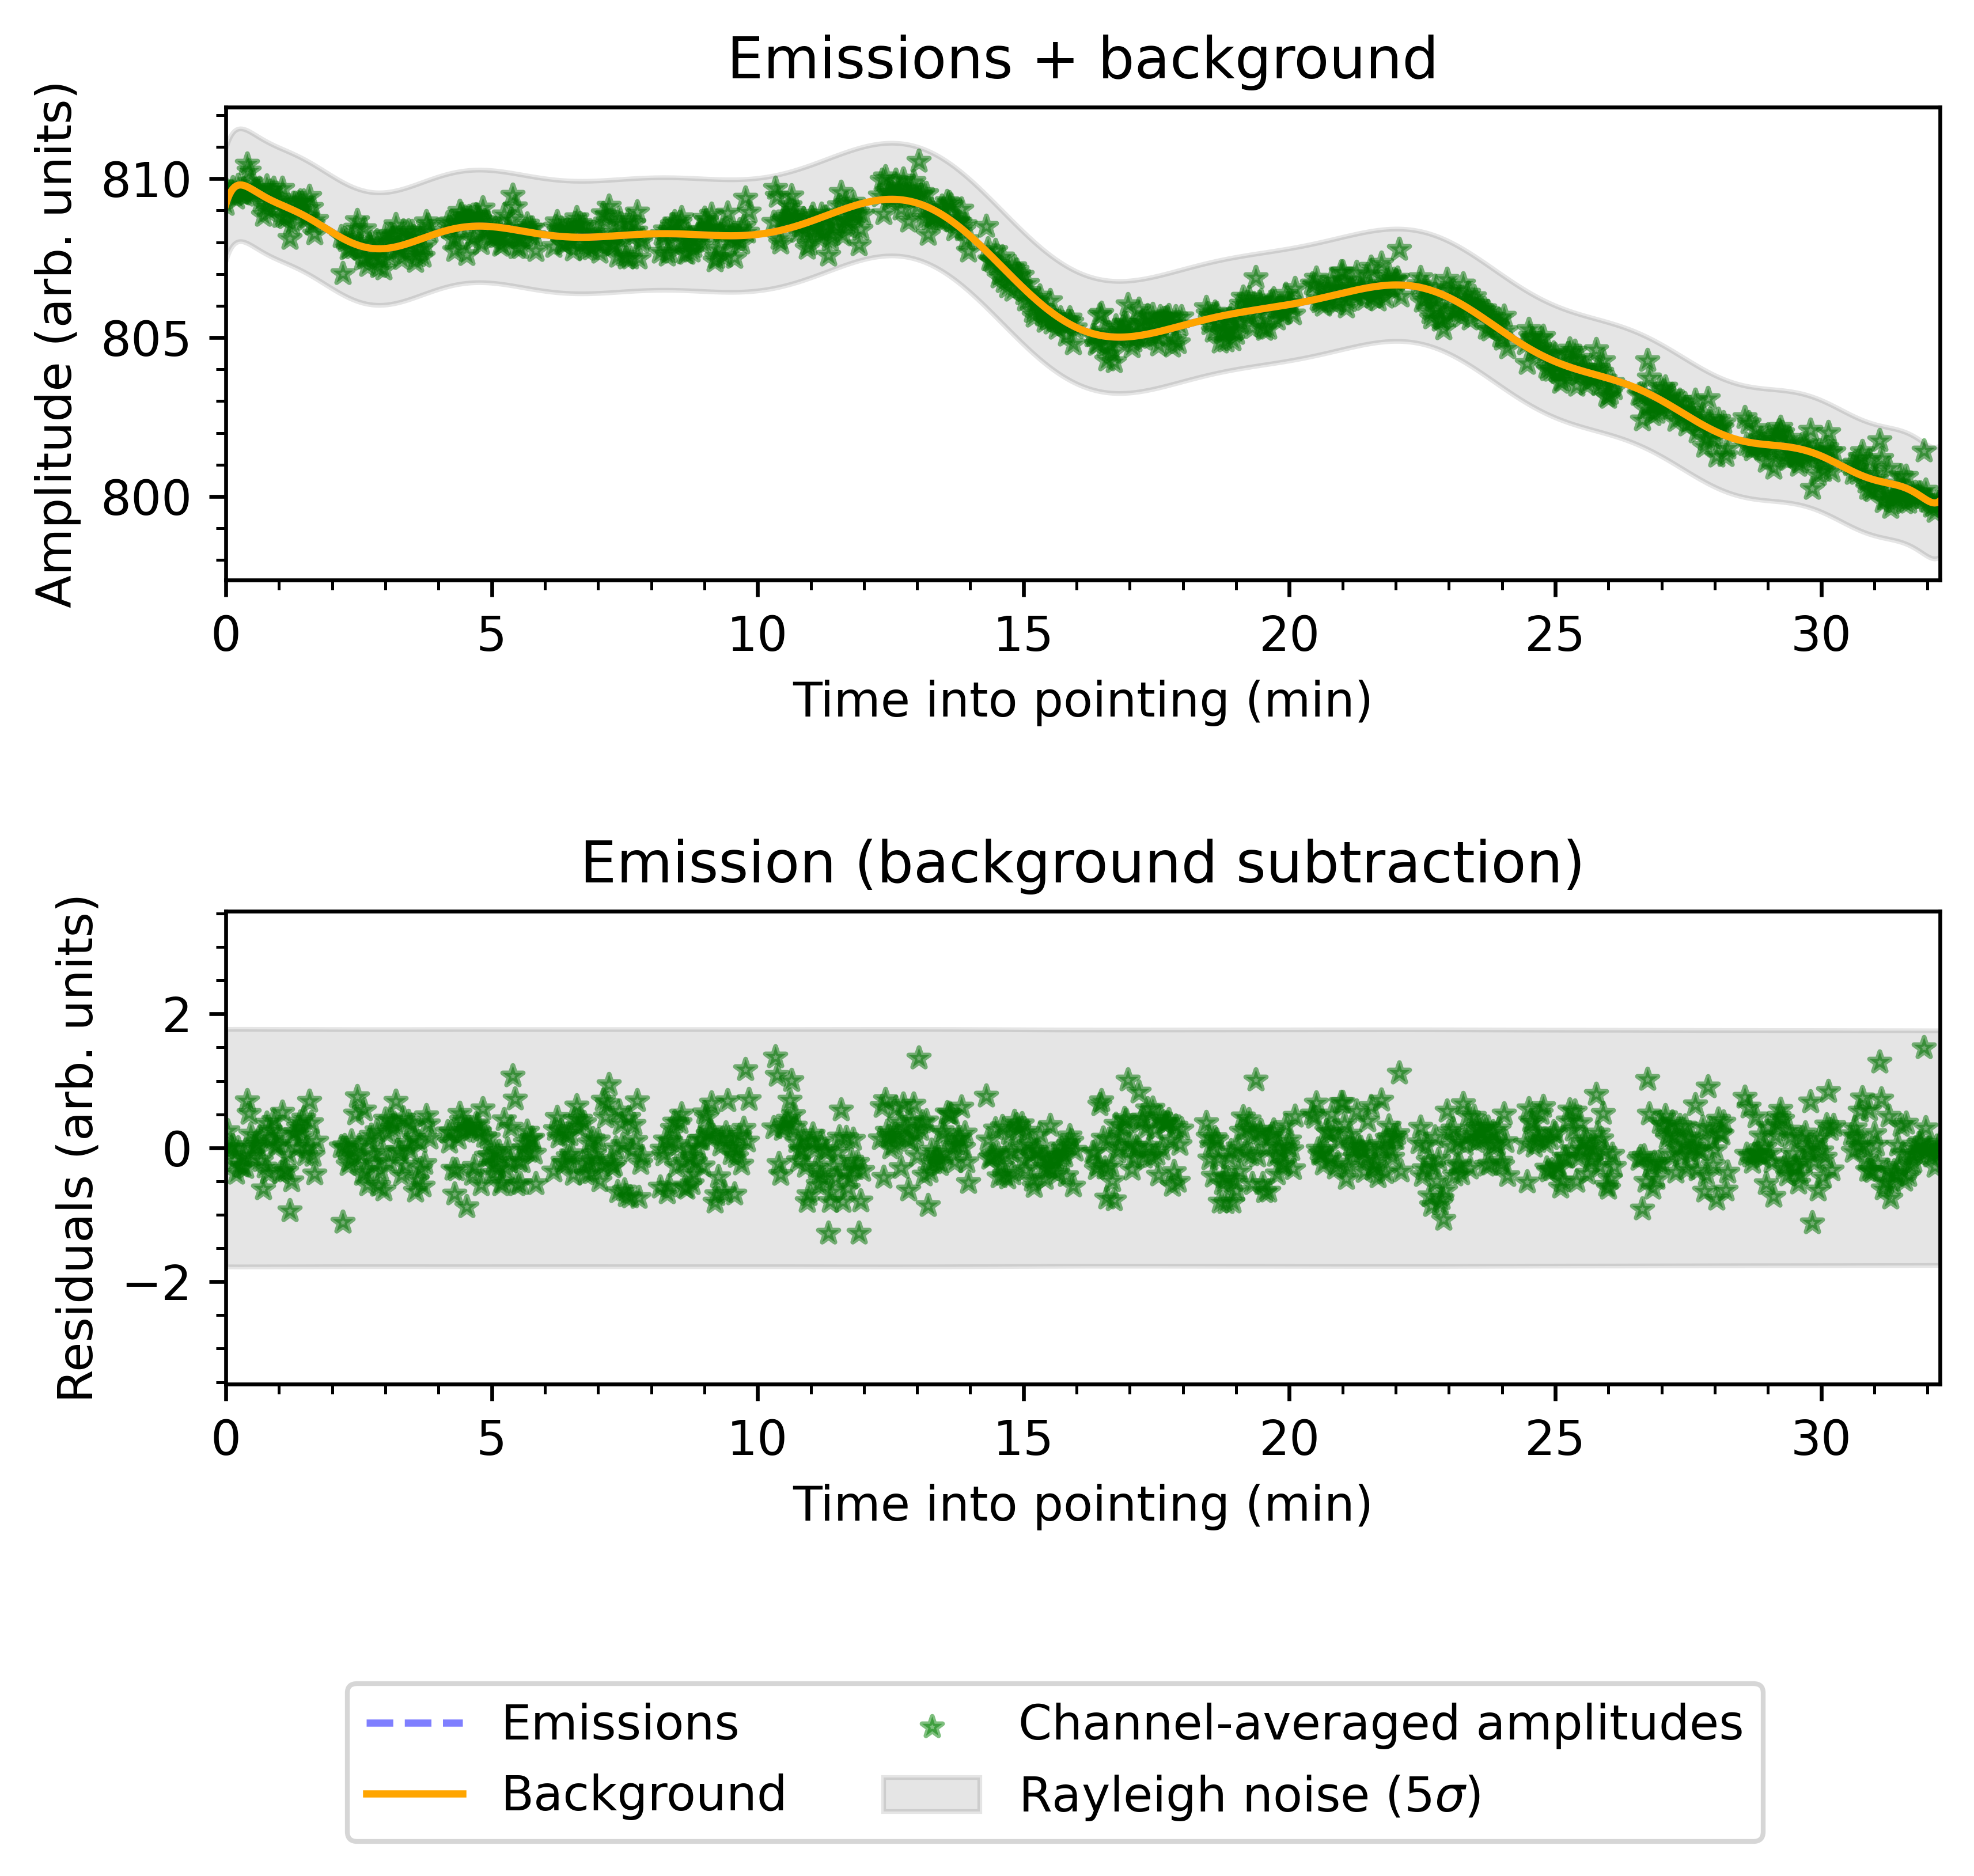

[ 1.76064672e+04  3.49292628e+01  1.20014721e+04  2.98847771e+01
  9.82067956e+03  4.87465071e+01  7.87196639e+03  3.01850533e+01
  4.01140060e+03  1.86111854e+01  7.51082531e+02  1.52314268e+00
  6.24523279e+01 -8.54458067e-01  4.49304243e+00 -5.24574049e-01
 -1.87347936e+00 -1.77224206e+00  2.45997430e+00  2.76875642e+00
 -2.32537698e+00 -1.23594545e+00  4.73388211e-01 -1.15005885e+00]


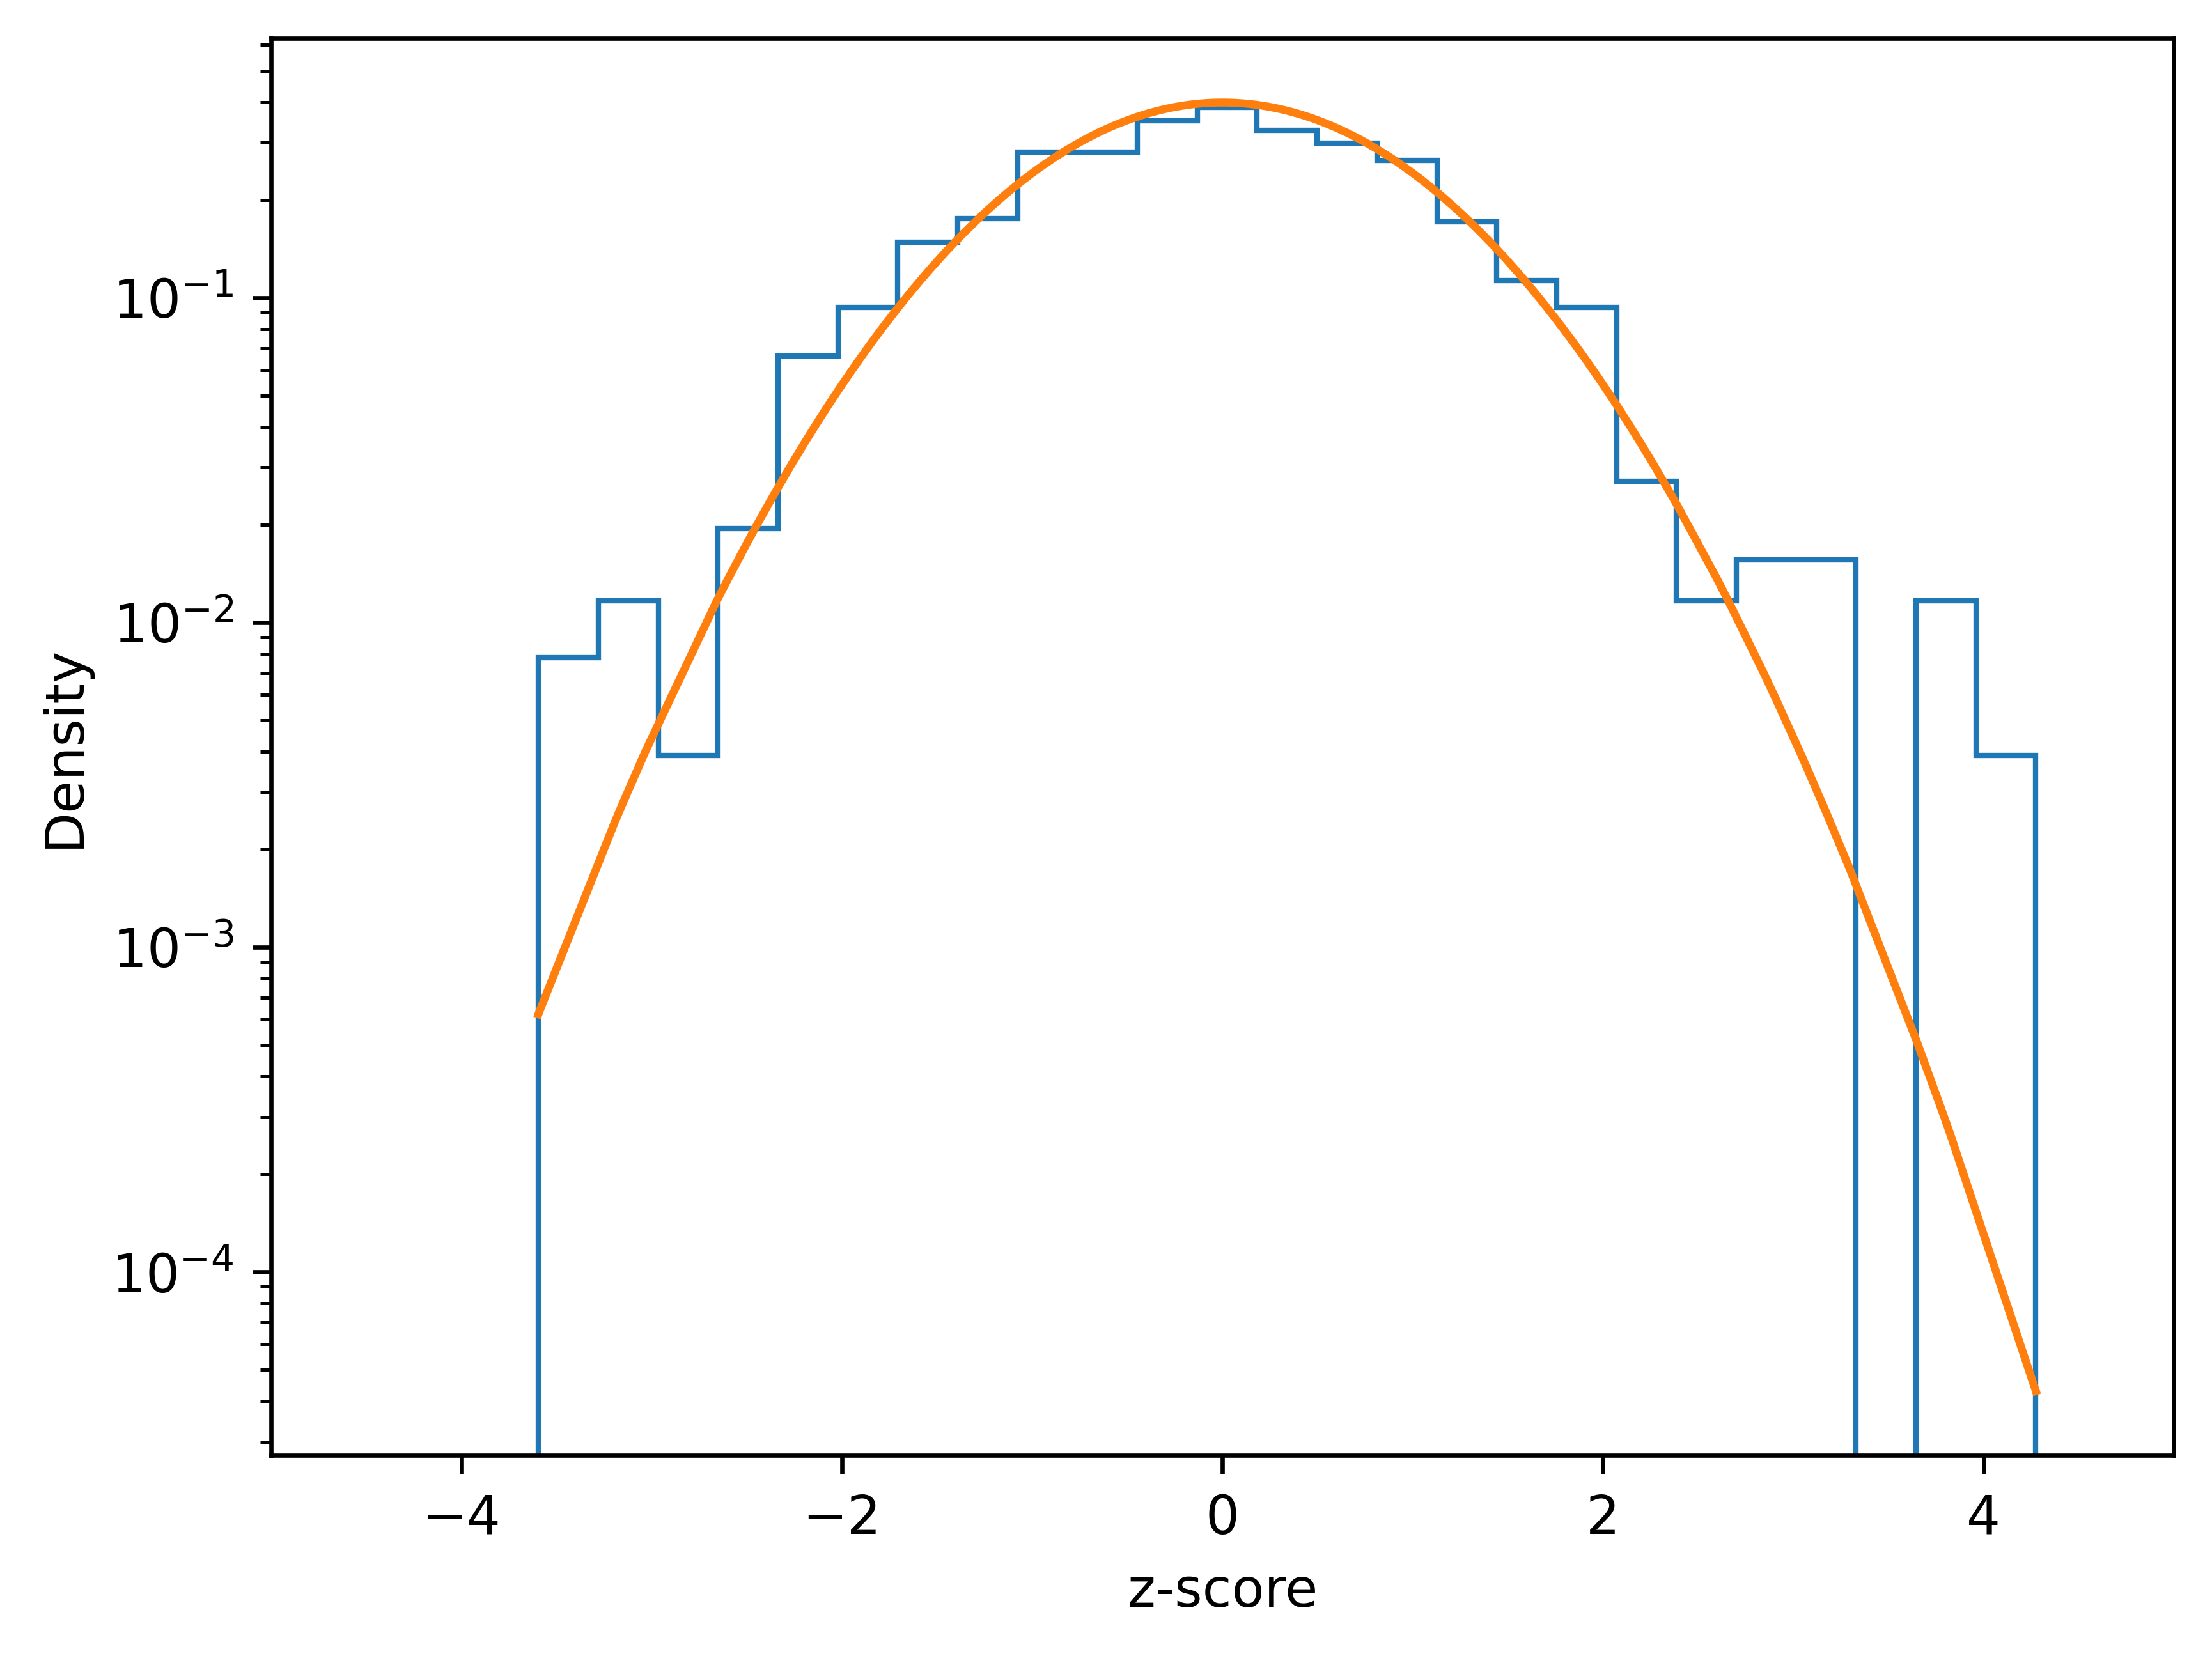

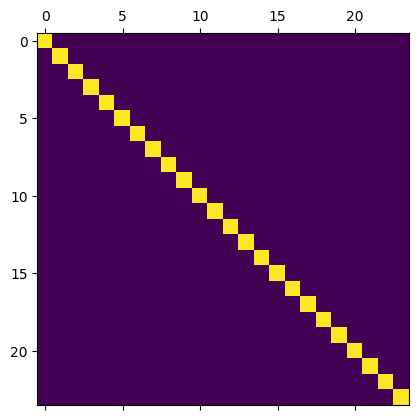

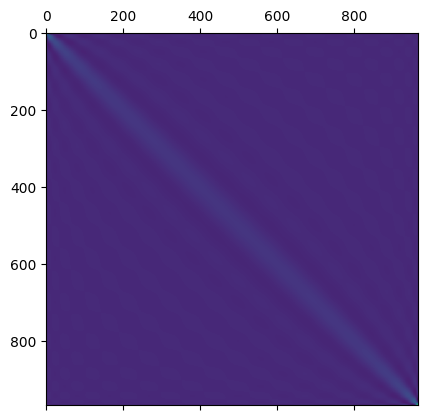

In [164]:
##Defining the function we now want to plot

def rcos_model(time, *params, show='all'):

    """ 
    The joint background + emissions model vs time.

    Args
    ----

    time:
        Time array to be plotted.
    
    params:
        Parameters consisting of concatenated DPSS coefficients + emission parameters arrays.

    show:
        If set to 'all', will return background + emissions. If set to 'background', will return background. If set to 'emit', will return emissions.
    
    Returns:
        background + emission, background only, or emission only, depending on the value of show.
    """
    N_terms=24
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    NW, K = 4, N_terms   
    basis = dpss(len(time), NW, K)
    design = basis.T
    
    background = design @ coeff

    emission = np.zeros_like(time)
    num_emissions = len(theta) // 3

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.where(np.abs(time - mu) <= sigma, True, False)
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))
        
    if show == 'all':
        return background + emission
    elif show == 'emit':
        return emission
    elif show == 'background':
        return background

print(rcos_fit)
plt.style.use('default')


##Plotting out our models and our data, plus our data minus the background model
figure, ax = plt.subplots(ncols=1, nrows=2, dpi=600)
ax[0].set_title("Emissions + background")
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit), color='blue', alpha=0.5, linestyle='--', label='Emissions')
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='background'), color='orange', alpha=1, label = 'Background')
ax[0].set_xlabel("Time into pointing (min)")
ax[0].set_ylabel("Amplitude (arb. units)")
ax[0].scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
ax[0].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[0].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)
figure.legend(bbox_to_anchor=(0.5, -0.18), loc = 'lower center', ncol=2)
plt.subplots_adjust(hspace=0.7)

ax[1].set_title('Emission (background subtraction)')
ax[1].set_xlabel("Time into pointing (min)")
#ax[1].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='blue', alpha=0.5, label = 'Emissions', linestyle='--')
ax[1].set_ylabel("Residuals (arb. units)")
ax[1].scatter(smooth_time*60*24, padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'), s=20, alpha=0.5, color='green', label='Residuals', marker='*')
ax[1].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[1].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)
ax[1].set_ylim(np.mean(-10*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background')),
               np.mean(10*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background')))
ax[0].minorticks_on()
ax[1].minorticks_on()
plt.show()

print(rcos_fit[:N_terms])

noise_err = (np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'))
z = np.sort((padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'))/noise_err)

plt.figure(dpi=600)
plt.hist(z[z < 6], bins='auto', histtype='step', density=True)
plt.plot(z[z < 6], np.exp(-z[z < 6]**2/2)/np.sqrt(2*np.pi), label='Standard normal Gaussian')
plt.xlim(-5, 5)
plt.yscale('log')
plt.xlabel('z-score')
plt.ylabel('Density')
plt.show()

NW, K = 4, N_terms
design = dpss(len(smooth_time), NW, K).T

sigma_p = la.inv(design.T @ la.inv(np.diag(noise_err)) @ design)
plt.matshow(sigma_p)
sigma_f = design @ sigma_p @ design.T
plt.matshow(sigma_f)

In [165]:
#Looking at a singular emission. This cell is WIP

noise_cov = np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background')

emissions = np.where(rcos_model(smooth_time, *rcos_fit, show='emit') != 0, padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'), np.nan)

da = np.diff(emissions)/emissions[np.isfinite(emissions)].max()


new_mask = np.where(rcos_model(smooth_time, *rcos_fit, show='emit') != 0, False, True)
plt.figure(figsize=(10, 5))
plt.scatter((smooth_time[np.isfinite(emissions)] - smooth_time[np.isfinite(emissions)].min())*60*60*24, emissions[np.isfinite(emissions)])
plt.yscale('linear')
plt.show()

print(emissions[np.isfinite(emissions)])
print(smooth_time)

roll_mean_da = np.convolve(da, np.ones(4)/4, mode='valid')
#print(roll_mean_da[np.isfinite(roll_mean_da)])

plt.figure(figsize=(10, 5))
#plt.scatter(smooth_time[0:]*60*60*24, emissions, s=20, alpha=0.5, color='blue', label='Emissions', marker='*')
plt.scatter((smooth_time - smooth_time.min())[1:]*60*60*24, da, s=20, alpha=0.5, color='green', label='Emission derivatives', marker='*')
plt.xlabel('Time into emission (s)')
plt.ylabel('Finite differences of SSINS amplitudes (arb. units)')
#plt.xlim(smooth_time.min()*60*60*24, smooth_time.max()*60*60*24)
#plt.scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

[ 0.08820578  0.08481081  0.08123236 ... -0.00994712 -0.00781917
 -0.00527024]


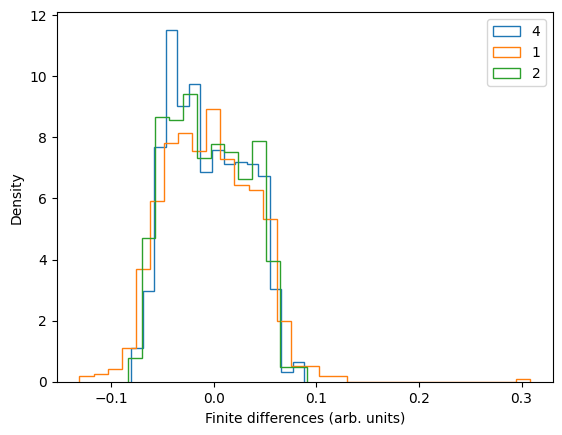

In [ ]:
emit_diffs = np.load('emit_diffs_4.npy')

print(emit_diffs)

plt.hist(emit_diffs, bins='auto', histtype='step', density=True, label='4')
plt.hist(np.load('emit_diffs.npy'), bins='auto', histtype='step', density=True, label='1')
plt.hist(np.load('emit_diffs_2.npy'), bins='auto', histtype='step', density=True, label='2')
plt.xlabel("Finite differences (arb. units)")
plt.ylabel("Density")
plt.legend()
plt.show()

#np.save('emit_diffs_4.npy', np.concatenate((emit_diffs, roll_mean_da[np.isfinite(roll_mean_da)])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


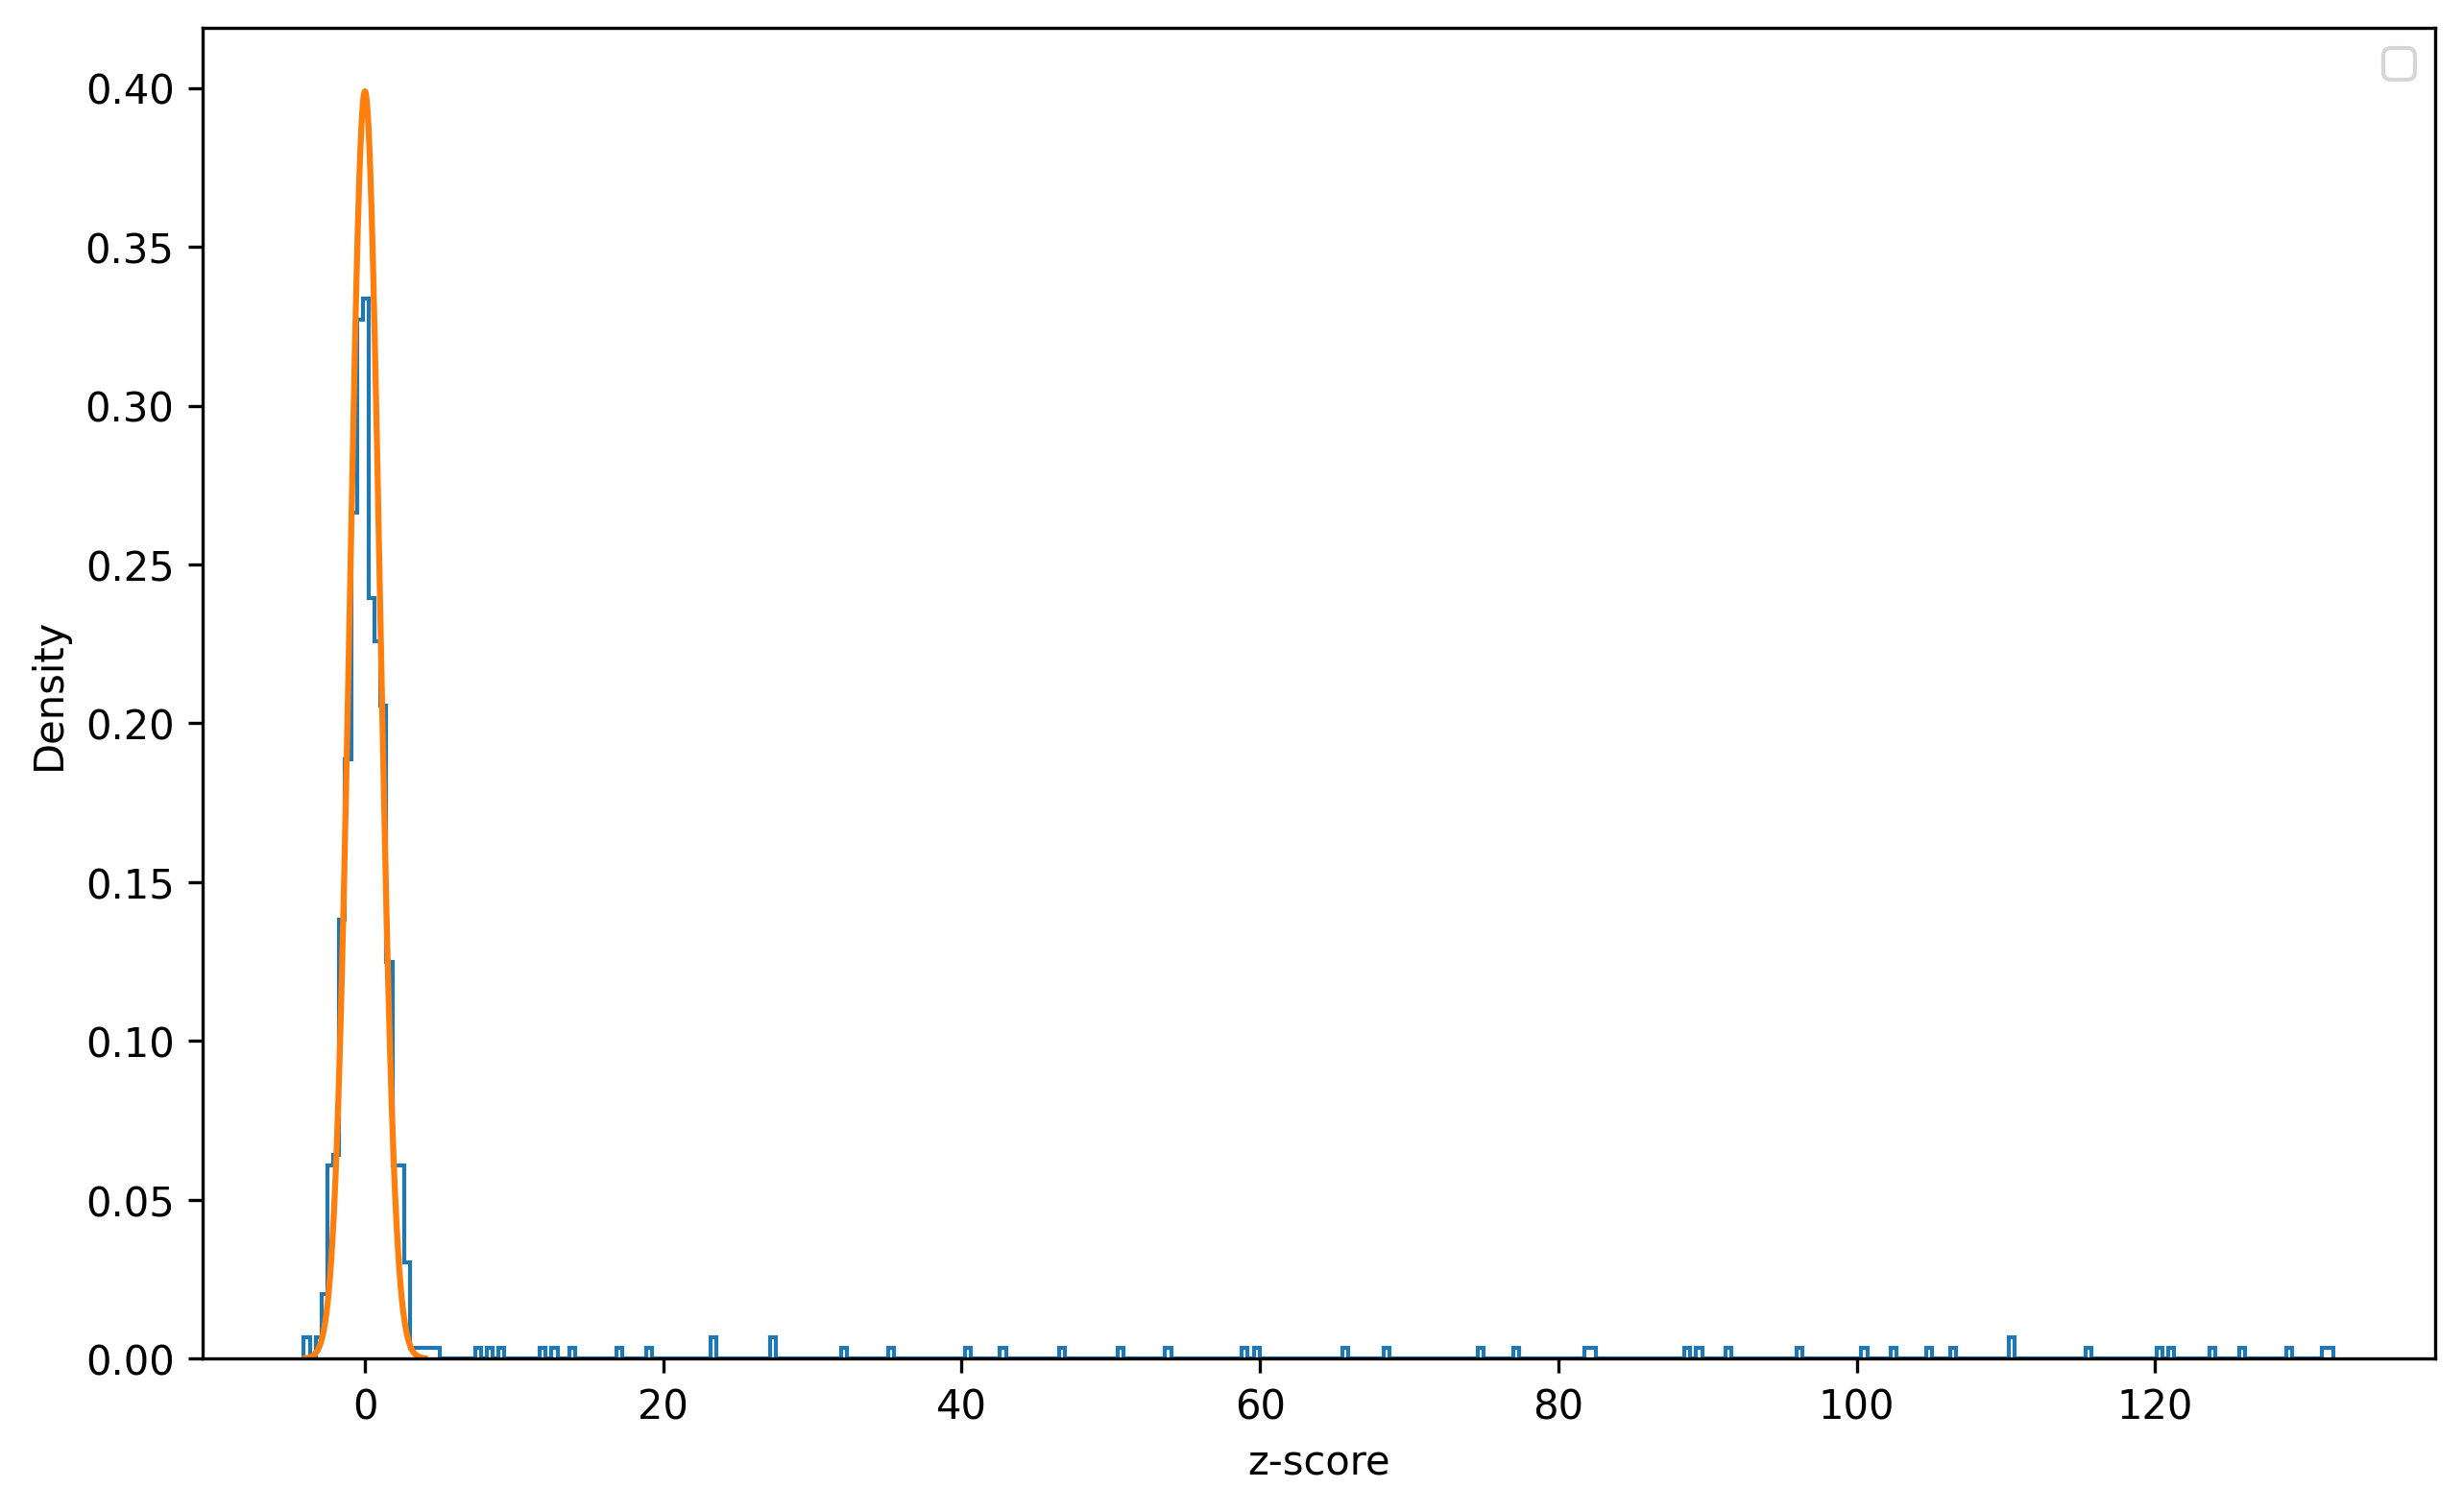

In [ ]:
#Testing out histograms for background subtracted data. Also WIP.

z_scores = (padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'))/(np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'))
z_scores = z_scores[np.isfinite(z_scores)]

x = np.linspace(-4, 4, 1000)


plt.figure(figsize=(10, 6), dpi=300)
plt.xlabel("z-score")
#plt.plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='orange', alpha=1, label = 'Emissions')
plt.ylabel("Density")
plt.hist(z_scores, bins='auto', histtype='step', density=True)
plt.plot(x, np.exp(-x**2/2)/np.sqrt(2*np.pi))
plt.yscale('linear')
#plt.xlim(-4, 4)
plt.legend()
plt.show()

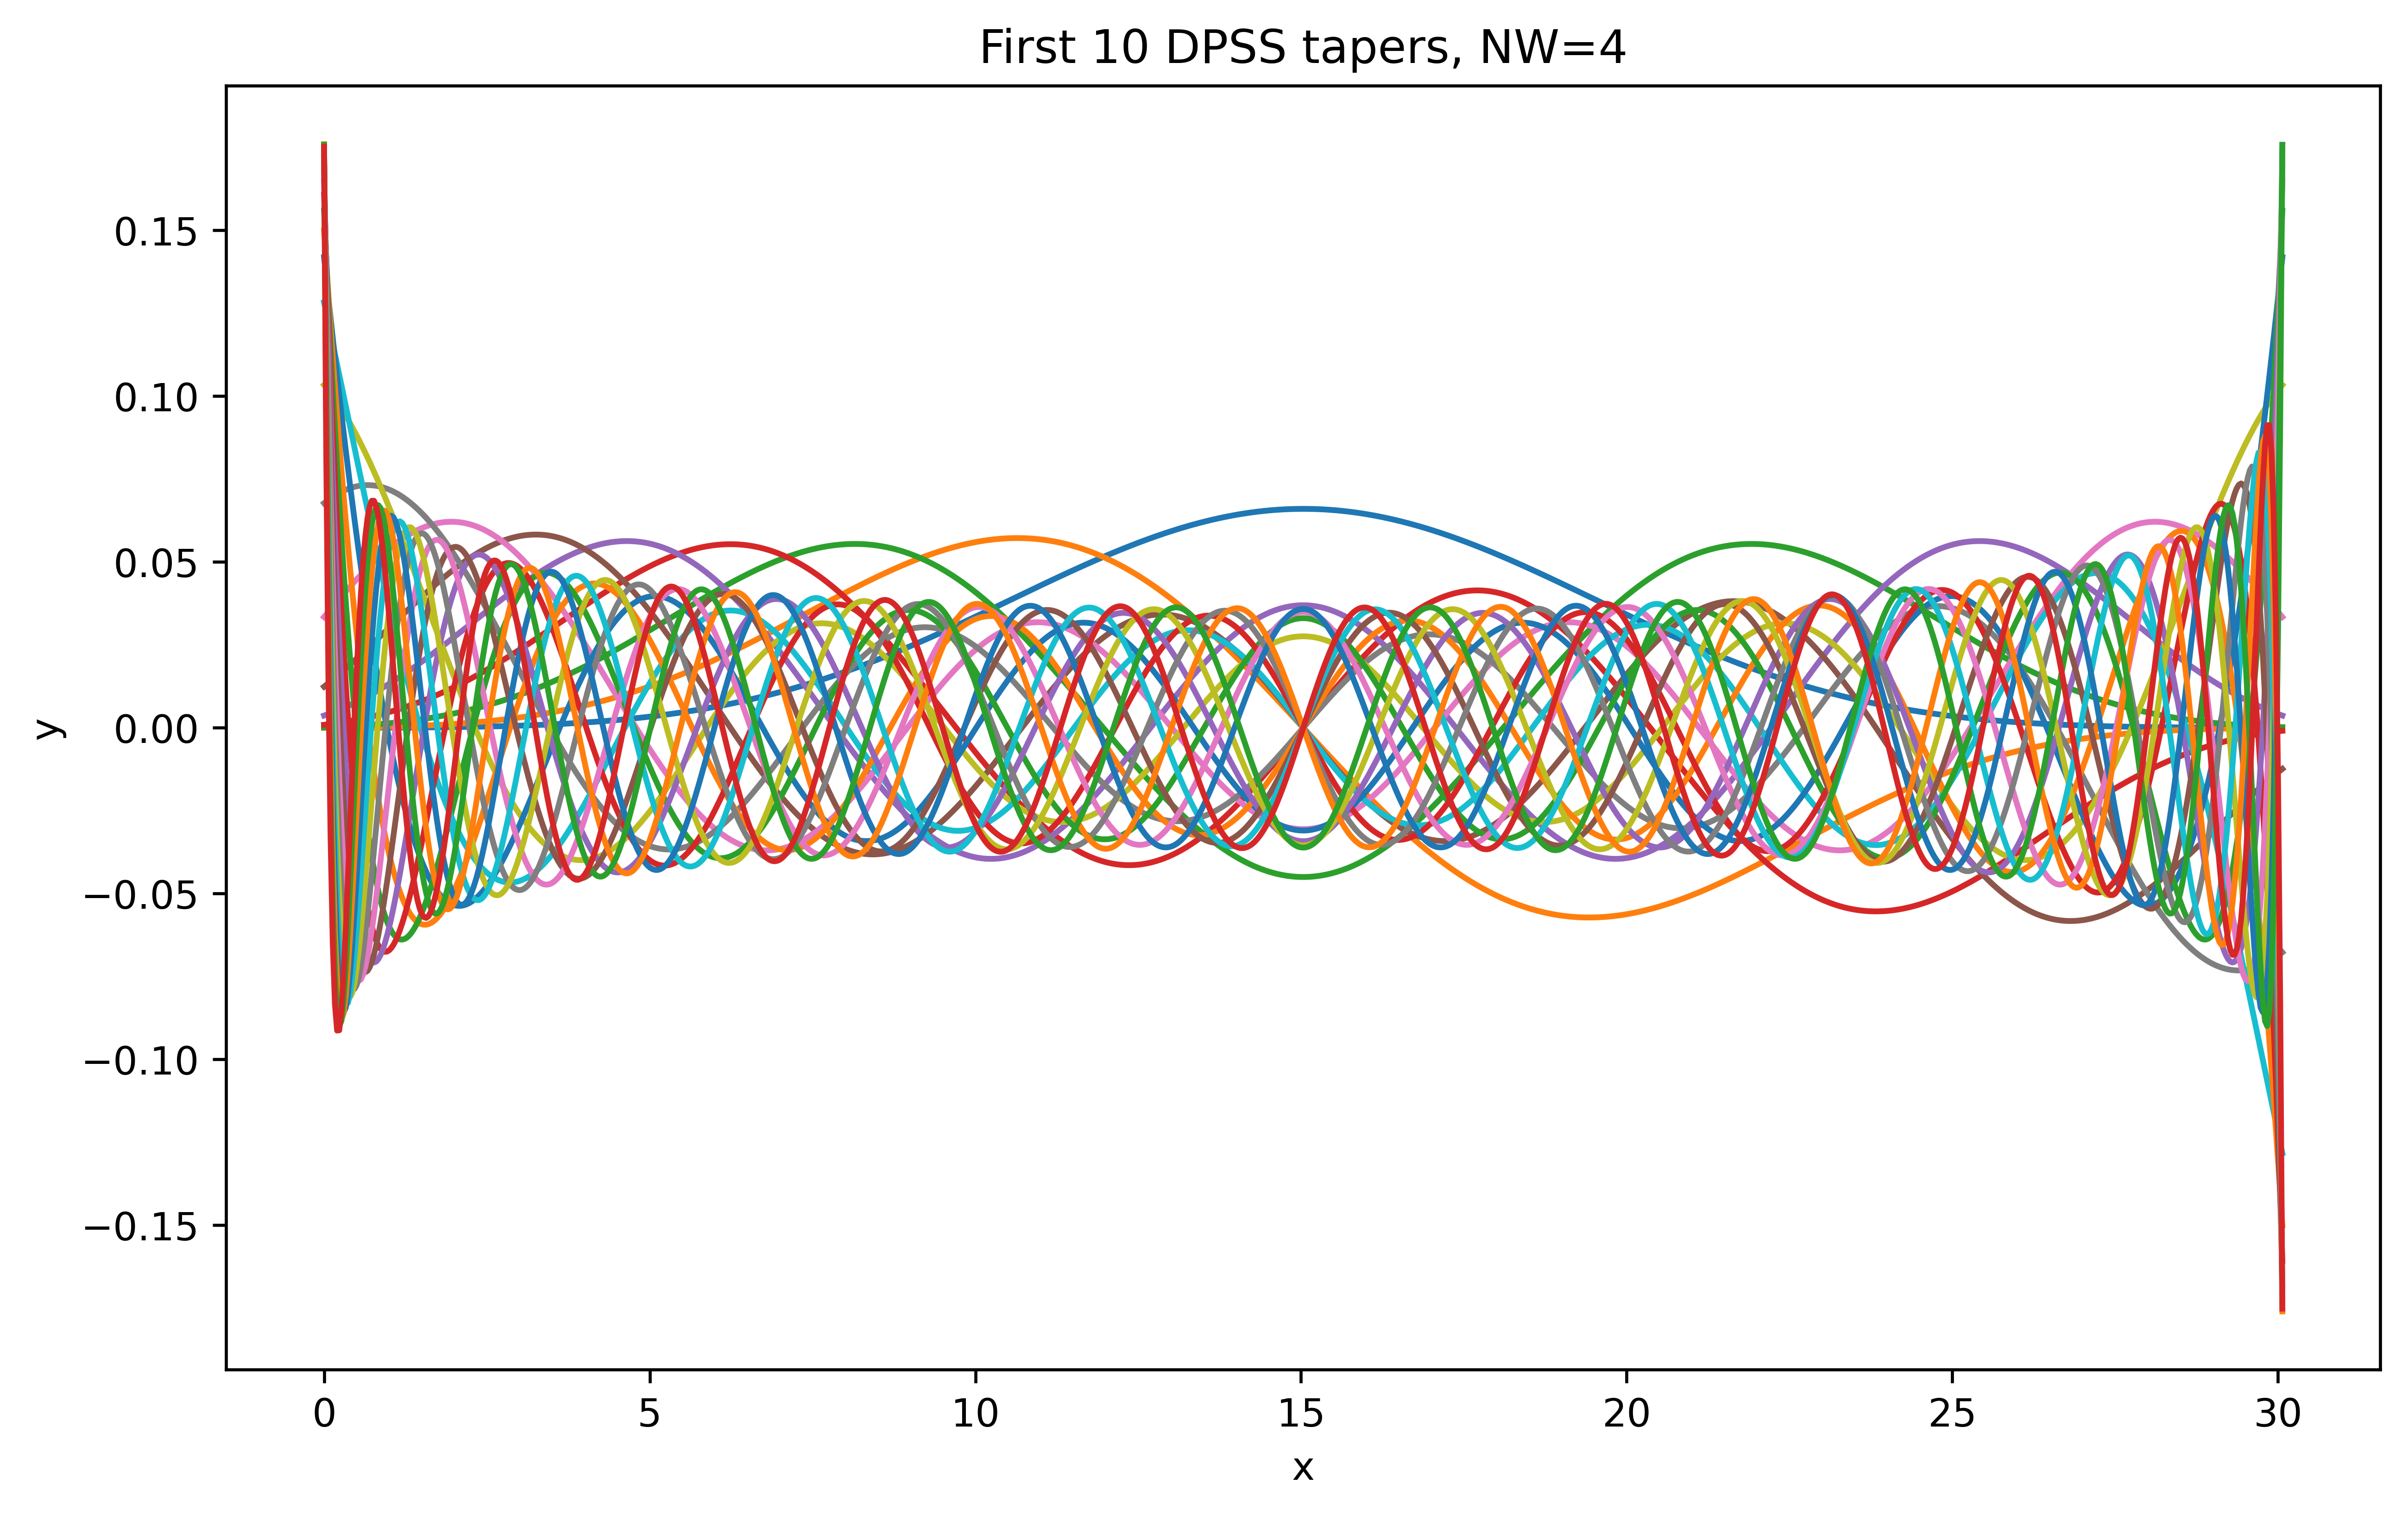

In [ ]:
NW, K = 4, 24

design = dpss(len(smooth_time), NW, K).T
plt.figure(figsize=(10,6), dpi=600)

for i in range(design.shape[1]):
    plt.plot(smooth_time*24*60, design.T[i])

plt.title('First 10 DPSS tapers, NW=4')
plt.xlabel('x')
plt.ylabel('y')
plt.show()